In [1]:
!pip3 install matplotlib colorama
!pip3 install adversarial-robustness-toolbox
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 45.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
from torch.quantization import MovingAverageMinMaxObserver
from torch.ao.quantization.observer import MinMaxObserver
from torch.quantization import QuantStub, DeQuantStub
from colorama import Fore, Style
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10
from art.preprocessing.standardisation_mean_std import StandardisationMeanStdPyTorch
from art.attacks.evasion.hop_skip_jump import HopSkipJump
import time
import pickle
import os
from math import log10, sqrt
import cv2
from torch.utils.data import DataLoader
torch.manual_seed(0)
torch.cuda.manual_seed(0)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


def PSNR(original, compressed):
    mse = np.mean((original.astype(np.float32) - compressed.astype(np.float32)) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 1.0  # Watch out. Floating Point Normalized max value
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def mean(listed):
    return sum(listed)/len(listed)

def accuracy(output, target):
    """ Computes the top 1 accuracy """
    with torch.no_grad():
        batch_size = target.size(0)

        _, pred = output.topk(1, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        correct_one = correct[:1].view(-1).float().sum(0, keepdim=True)
        return correct_one.mul_(100.0 / batch_size).item()

def imshow(img):
    plt.imshow(img)
    plt.show(block=False)
    
def imshow_gray(img):
    plt.imshow(img, cmap = "gray")
    plt.show(block=False)
    
def grayscale(img):
    # R G B 
    # Reshape the image to (32, 32, 3) instead of (3, 32, 32)
    reshaped_image = np.transpose(img, (1, 2, 0))
    # Convert the reshaped image to grayscale
    grayscale_image = np.dot(reshaped_image, [0.2989, 0.5870, 0.1140])
    # Normalize the grayscale image between 0 and 1
    grayscale_image = grayscale_image / 255.0
    # If you want to keep the shape as (1, 32, 32), reshape it back
    grayscale_image = np.expand_dims(grayscale_image, axis=0)
    return grayscale_image[0]

def predict(img):
  img = torch.from_numpy(img)
  img = F.normalize(img, [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
  return img.numpy()


def print_size_of_model(model):
    """ Prints the real size of the model """
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

def train(model: nn.Module, dataloader: DataLoader, cuda=False, q=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)#, momentum=0.9, dampening=0,weight_decay=0.0005, nesterov=True)
    model.train()
    for epoch in range(1):  # loop over the dataset multiple times
        running_loss = AverageMeter('loss')
        acc = AverageMeter('train_acc')
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if cuda:
              inputs = inputs.cuda()
              labels = labels.cuda()
            # zero the parameter gradients
            optimizer.zero_grad()
            if epoch>=3 and q:
              model.apply(torch.quantization.disable_observer)
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss.update(loss.item(), outputs.shape[0])
            acc.update(accuracy(outputs, labels), outputs.shape[0])
            if i % 100 == 0:    # print every 100 mini-batches
                print('[%d, %5d] ' %
                    (epoch + 1, i + 1), running_loss, acc)
    print('Finished Training')


def test(model: nn.Module, dataloader: DataLoader, cuda=False) -> float:
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            if cuda:
              inputs = inputs.cuda()
              labels = labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def unpredict(img):
  img = torch.from_numpy(img)
  img = F.normalize(img, [-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010], [1/0.2023, 1/0.1994, 1/0.2010])
  return img.numpy()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


100%|██████████| 170498071/170498071 [00:04<00:00, 34728869.95it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Files already downloaded and verified


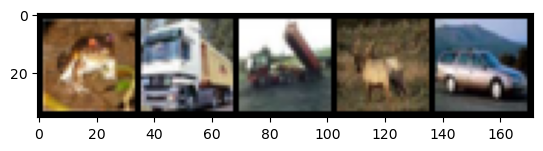

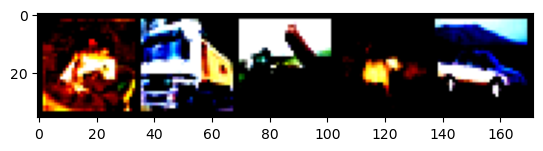

In [3]:
# Step 1: Load the CIFAR10 dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_cifar10()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True, num_workers=16, pin_memory=True)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False, num_workers=16, pin_memory=True)

test_data = datasets.CIFAR10(root="./data",train=False,download=True,transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

# show images
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

unnorm_pics = torchvision.utils.make_grid(torch.from_numpy(x_train[0:5])).numpy()
unnormalized = np.transpose(unnorm_pics, (1, 2, 0) )
imshow(unnormalized)

norm_pics = torchvision.utils.make_grid(torch.from_numpy(predict(x_train)[0:5])).numpy()
starter = np.transpose(norm_pics, (1, 2, 0) )
imshow(starter)

In [27]:
def train(model: nn.Module, dataloader: DataLoader,testloader: DataLoader, cuda=False, q=False):
    flagged = False
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, dampening=0,weight_decay=0.0005, nesterov=True)
    model.train()
    for epoch in range(60):  # loop over the dataset multiple times
        if flagged:
            break
        else:
            running_loss = AverageMeter('loss')
            acc = AverageMeter('train_acc')
            for i, data in enumerate(dataloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                if cuda:
                  inputs = inputs.cuda()
                  labels = labels.cuda()
                # zero the parameter gradients
                optimizer.zero_grad()
                if epoch>=3 and q:
                  model.apply(torch.quantization.disable_observer)
                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                # print statistics
                running_loss.update(loss.item(), outputs.shape[0])
                acc.update(accuracy(outputs, labels), outputs.shape[0])
                if i % 100 == 0:    # print every 100 mini-batches
                    print('[%d, %5d] ' %
                        (epoch + 1, i + 1), running_loss, acc)
            score = test(model, testloader, cuda=True)
            print('Accuracy of the network on the test images: {}% - FP32'.format(score))
            score1 = test(model, dataloader, cuda=True)
            print('Accuracy of the network on the adversarial set images: {}% - FP32'.format(score1))
            if (score >= 91.28 and score1 >= 99.99):
                flagged = True
                #pass
            model.train()
    print('Finished Training')


model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
#model.load_state_dict(torch.load("2nd_Iteration_retrained_model_quant_92.0acc.pkl"))
model.to("cuda")
model.eval()
score = test(model, testloader, cuda=True)
print('Accuracy of the network on the test images: {}% - FP32'.format(score))

file = open("x_train_res20_fp_10k_3rd_Dataset.pkl",'rb')
x_train_set = pickle.load(file)

sample_size = 10000

x_train_set = x_train_set[0:sample_size]
#print(x_train_set.shape)
y_train_set = np.empty((sample_size)).astype(np.int8)

for i in range(sample_size):
    y_train_set[i] = np.where(y_train[i] == 1)[0][0]
    
print(x_train_set.shape, y_train_set.shape)


trainingSet = torch.utils.data.TensorDataset(torch.from_numpy(predict(x_train_set)).type(torch.FloatTensor), torch.from_numpy(y_train_set).type(torch.LongTensor))

train_dev_sets = torch.utils.data.ConcatDataset([trainingSet])#, trainOriginalSet])
def custom_collate(batch):
    # Combine a list of samples into a batch
    data, labels = zip(*batch)
    data = torch.stack(data)
    labels = torch.tensor(labels, dtype=torch.long)
    return data, labels


retrain_loader = torch.utils.data.DataLoader(dataset=train_dev_sets, batch_size=64, num_workers=16, pin_memory=True, shuffle=True, collate_fn=custom_collate)

train(model,retrain_loader,testloader,cuda=True,q=False)

score = test(model, testloader, cuda=True)
print('Accuracy of the network on the test images: {}% - FP32'.format(score))

#92.6 -> 92.18 adam,both_sets,1e-4 lr

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Accuracy of the network on the test images: 92.6% - FP32
(10000, 3, 32, 32) (10000,)
[1,     1]  loss 2.579911 (2.579911) train_acc 42.187500 (42.187500)
[1,   101]  loss 0.364608 (1.087380) train_acc 84.375000 (69.863861)
Accuracy of the network on the test images: 89.58% - FP32
Accuracy of the network on the adversarial set images: 90.74% - FP32
[2,     1]  loss 0.332398 (0.332398) train_acc 92.187500 (92.187500)
[2,   101]  loss 0.262298 (0.303177) train_acc 87.500000 (89.217203)
Accuracy of the network on the test images: 90.65% - FP32
Accuracy of the network on the adversarial set images: 94.96% - FP32
[3,     1]  loss 0.071588 (0.071588) train_acc 98.437500 (98.437500)
[3,   101]  loss 0.054539 (0.201192) train_acc 100.000000 (92.806312)
Accuracy of the network on the test images: 90.77% - FP32
Accuracy of the network on the adversarial set images: 96.87% - FP32
[4,     1]  loss 0.085085 (0.085085) train_acc 98.437500 (98.437500)
[4,   101]  loss 0.228040 (0.158336) train_acc 92.

In [32]:
torch.save(model.state_dict(), "3rd_Iteration_retrained_model_quant_{}acc.pkl".format(score))

In [20]:
file = open("x_train_res20_fp_10k_3rd_Dataset.pkl",'rb')
x_train_set = pickle.load(file)

sample_size = 10000

x_train_set = x_train_set[0:sample_size]
#print(x_train_set.shape)
y_train_set = np.empty((sample_size)).astype(np.int8)

for i in range(sample_size):
    y_train_set[i] = np.where(y_train[i] == 1)[0][0]
    
print(x_train_set.shape, y_train_set.shape)


trainingSet = torch.utils.data.TensorDataset(torch.from_numpy(predict(x_train_set)).type(torch.FloatTensor), torch.from_numpy(y_train_set).type(torch.LongTensor))

train_dev_sets = torch.utils.data.ConcatDataset([trainingSet])#, trainOriginalSet])
def custom_collate(batch):
    # Combine a list of samples into a batch
    data, labels = zip(*batch)
    data = torch.stack(data)
    labels = torch.tensor(labels, dtype=torch.long)
    return data, labels


retrain_loader = torch.utils.data.DataLoader(dataset=train_dev_sets, batch_size=64, num_workers=16, pin_memory=True, shuffle=True, collate_fn=custom_collate)


(10000, 3, 32, 32) (10000,)


In [21]:
#Sanity Check
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
#model.load_state_dict(torch.load("1st_Iteration_retrained_model_92.55acc.pkl"))
model.to("cuda")
model.eval()
score = test(model, retrain_loader, cuda=True)
print('Accuracy of the network on the 3rd adversarial set from 2nd iteration model (should be <20%): {}% - FP32'.format(score))

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Accuracy of the network on the 3rd adversarial set from 2nd iteration model (should be <20%): 37.93% - FP32


In [16]:
# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, dampening=0,weight_decay=0.0005, nesterov=True)
criterion = nn.CrossEntropyLoss()

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    preprocessing=((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    input_shape=(3, 32, 32),
    nb_classes=10,
    device_type = "gpu"
)
print("HopSkipJump Attack Initialization")
attack = HopSkipJump(classifier,64,targeted = False,verbose = True)
#x_test_hop_res20org has 100 examples with 3200samples and 92% precision
x_test_hop_res20org_1 = attack.generate(x_train[0:400])

HopSkipJump Attack Initialization


HopSkipJump:   0%|          | 0/400 [00:00<?, ?it/s]

In [17]:
with open("x_train_hop_res20_400_quantzed_dataset_2retrained.pkl",'wb') as f:
    pickle.dump(x_test_hop_res20org_1,f)

In [ ]:
"""file = open("/kaggle/input/resnet20fp-retrained/x_test_res20_fp_400_psnr_check_1retrain.pkl",'rb')
x_train_set = pickle.load(file)

file = open("/kaggle/input/resnet20fp-retrained/x_test_res20_fp_400_psnr_check_1retrain.pkl",'rb')
x_test_set_1_retrain = pickle.load(file)

file = open("/kaggle/input/resnet20fp-retrained/x_train_res20_fp_400_psnr_check_1retrain.pkl",'rb')
x_train_set_1_retrain = pickle.load(file)"""


In [18]:
from pandas import DataFrame
from scipy.stats.mstats import gmean
avg_20_norm = []
avg_20_grey = []
avg_20_norm_bf = []
avg_20_grey_bf = []
avg_20_norm_test = []
avg_20_grey_test = []

for l in range(0,400):
    avg_20_norm.append(PSNR(x_train[l],x_test_hop_res20org_1[l]))
    avg_20_grey.append(PSNR(grayscale(x_train[l]),grayscale(x_test_hop_res20org_1[l])))
    """avg_20_norm_bf.append(PSNR(x_train[l],x_train_set[l]))
    avg_20_grey_bf.append(PSNR(grayscale(x_train[l]),grayscale(x_train_set[l])))
    avg_20_norm_test.append(PSNR(x_test[l],x_test_set_1_retrain[l]))
    avg_20_grey_test.append(PSNR(grayscale(x_test[l]),grayscale(x_test_set_1_retrain[l])))"""

print(Fore.RED + "ResNet20 Normal Re-trained Average")

print(Style.RESET_ALL + "RGB Average Result: \n",
          "\tGeometric Mean: " + Fore.GREEN + "{:.4f}dB".format(gmean(avg_20_norm)) + Style.RESET_ALL + " Mean: " + Fore.GREEN + "{:.4f}dB".format(mean(avg_20_norm)),
          Style.RESET_ALL + "\nGrayscaled Result: \n",
          "\tGeometric Mean: " + Fore.BLUE + "{:.4f}dB".format(gmean(avg_20_grey)) + Style.RESET_ALL + " Mean: " + Fore.BLUE + "{:.4f}dB".format(mean(avg_20_grey)),
      Fore.RED + "\nResNet20 Normal Pre-Retrain Average",
      """Style.RESET_ALL + "\nRGB Average Result: \n",
          "\tGeometric Mean: " + Fore.GREEN + "{:.4f}dB".format(gmean(avg_20_norm_bf)) + Style.RESET_ALL + " Mean: " + Fore.GREEN + "{:.4f}dB".format(mean(avg_20_norm_bf)),
          Style.RESET_ALL + "\nGrayscaled Result: \n",
          "\tGeometric Mean: " + Fore.BLUE + "{:.4f}dB Mean: {:.4f}dB".format(gmean(avg_20_grey_bf),mean(avg_20_grey_bf)),
      Fore.RED + "\nResNet20 Normal Pre-Retrain Average Testing Set",
      Style.RESET_ALL + "\nRGB Average Result: \n",
          "\tGeometric Mean: " + Fore.GREEN + "{:.4f}dB".format(gmean(avg_20_norm_test)) + Style.RESET_ALL + " Mean: " + Fore.GREEN + "{:.4f}dB".format(mean(avg_20_norm_test)),
          Style.RESET_ALL + "\nGrayscaled Result: \n",
          "\tGeometric Mean: " + Fore.BLUE + "{:.4f}dB Mean: {:.4f}dB".format(gmean(avg_20_grey_test),mean(avg_20_grey_test))"""
          )
print("\n")


ResNet20 Normal Re-trained Average
RGB Average Result: 
 	Geometric Mean: 48.3763dB Mean: 48.7785dB 
Grayscaled Result: 
 	Geometric Mean: 97.7995dB Mean: 98.0047dB 
ResNet20 Normal Pre-Retrain Average Style.RESET_ALL + "
RGB Average Result: 
",
          "	Geometric Mean: " + Fore.GREEN + "{:.4f}dB".format(gmean(avg_20_norm_bf)) + Style.RESET_ALL + " Mean: " + Fore.GREEN + "{:.4f}dB".format(mean(avg_20_norm_bf)),
          Style.RESET_ALL + "
Grayscaled Result: 
",
          "	Geometric Mean: " + Fore.BLUE + "{:.4f}dB Mean: {:.4f}dB".format(gmean(avg_20_grey_bf),mean(avg_20_grey_bf)),
      Fore.RED + "
ResNet20 Normal Pre-Retrain Average Testing Set",
      Style.RESET_ALL + "
RGB Average Result: 
",
          "	Geometric Mean: " + Fore.GREEN + "{:.4f}dB".format(gmean(avg_20_norm_test)) + Style.RESET_ALL + " Mean: " + Fore.GREEN + "{:.4f}dB".format(mean(avg_20_norm_test)),
          Style.RESET_ALL + "
Grayscaled Result: 
",
          "	Geometric Mean: " + Fore.BLUE + "{:.4f}dB Mean:

In [ ]:
"""preview = np.empty((3,3,32,32)).astype(np.float32)
temp_arr = np.empty((3,3,32,32)).astype(np.float32)
for indexed in range(10):
    indexed = 160
    temp_arr[0] = x_train[indexed] * 255.0
    temp_arr[1] = x_train_set[indexed] * 255.0
    temp_arr[2] = x_test_hop_res20org[indexed] * 255.0
    unnorm_pics = torchvision.utils.make_grid(torch.from_numpy(temp_arr.astype(np.int8))).numpy()
    unnormalized = np.transpose(unnorm_pics, (1, 2, 0) )
    imshow(unnormalized)

    unnorm_pics = torchvision.utils.make_grid(torch.from_numpy(x_train[indexed])).numpy()
    unnormalized = np.transpose(unnorm_pics, (1, 2, 0) )
    imshow(unnormalized)

    unnorm_pics = torchvision.utils.make_grid(torch.from_numpy(x_train_set[indexed])).numpy()
    unnormalized = np.transpose(unnorm_pics, (1, 2, 0) )
    imshow(unnormalized)

    unnorm_pics = torchvision.utils.make_grid(torch.from_numpy(x_test_hop_res20org[indexed])).numpy()
    unnormalized = np.transpose(unnorm_pics, (1, 2, 0) )
    imshow(unnormalized)
"""